# US State Corona Virus Testing and Cases

> **Authors**
- [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)
- [Peifan Wu *UBC*](https://economics.ubc.ca/faculty-and-staff/peifan-wu/)


**Prerequisites**

- [Regression](regression.ipynb)  
- [Data Visualization: Rules and Guidelines](visualization_rules.ipynb)  
- [Visualizing Corona Virus](covid-trends.ipynb)  


**Outcomes**

- Visualize data on Covid test numbers and results  

## Outline

- [US State Corona Virus Testing and Cases](#US-State-Corona-Virus-Testing-and-Cases)  
  - [Introduction](#Introduction)  
  - [Data](#Data)  
  - [Visualizations](#Visualizations)  

In [1]:
# Uncomment following line to install on colab
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

## Introduction

This notebook works with daily data on Covid-19 tests and results.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection, preprocessing
)

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

## Data

We will use data from the [Covid Tracking
Project.](https://covidtracking.com/) This site gathers data
on Covid-19 tests and results in the US. It has information at the
state level. It is updated daily.

In [3]:
sinfo = pd.read_csv('https://covidtracking.com/api/states/info.csv')
sdaily = pd.read_csv('https://covidtracking.com/api/states/daily.csv')
sdaily["date"] = pd.to_datetime(sdaily["date"].map(str),  format="%Y%m%d")

## Visualizations

Let’s see the total number of tests and their outcomes vs time.

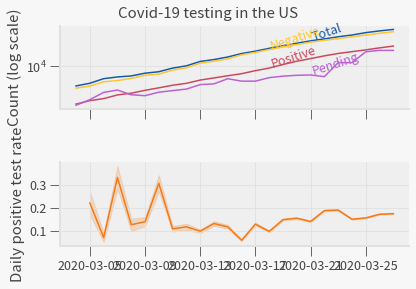

In [4]:
fig, ax = plt.subplots(2,1, sharex=True)
colors = qeds.themes.COLOR_CYCLE
tot = sdaily.groupby("date").sum()
ax[0].plot(tot.index, tot["total"], color=colors[0])
i = round(0.7*len(tot.index))
slope = (np.log(tot["total"][i])-np.log(tot["total"][0]))/i
angle = np.tan(slope)*360/(2*np.pi)
ax[0].annotate("Total", (tot.index[i], tot["total"][i]*1.05), color=colors[0], rotation=angle)

ax[0].plot(tot.index, tot["positive"], color=colors[1])
i = round(0.6*len(tot.index))
ax[0].annotate("Positive", (tot.index[i], tot["positive"][i]*1.05), color=colors[1], rotation=angle)

ax[0].plot(tot.index, tot["negative"], color=colors[2])
i = round(0.6*len(tot.index))
ax[0].annotate("Negative", (tot.index[i], tot["negative"][i]*0.94), color=colors[2], rotation=angle)

ax[0].plot(tot.index, tot["pending"], color=colors[3])
i = round(0.7*len(tot.index))
ax[0].annotate("Pending", (tot.index[i], tot["pending"][i]*1.05), color=colors[3],rotation=angle)

ax[0].set_yscale('log')
ax[0].set_ylabel("Count (log scale)")

n = tot["positive"].diff()+tot["negative"].diff()
prate = tot["positive"].diff()/n
se = np.sqrt(prate*(1-prate)/n)
ax[1].plot(tot.index, prate, color=colors[4])
ax[1].fill_between(tot.index, prate+1.96*se, prate-1.96*se, alpha=0.2, color=colors[4])
ax[1].set_ylabel("Daily positive test rate")
fig.suptitle("Covid-19 testing in the US")
fig.tight_layout()

And now some state level plots.

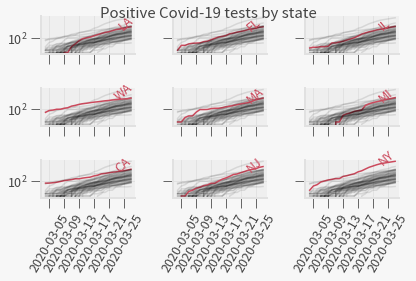

In [5]:
def stateplot(focusstate, var, ax):
    for state, _df in sdaily.groupby("state"):
        df = _df.copy()
        df = df.set_index("date").sort_index()
        if (state==focusstate):
            alpha = 1.0
            color=colors[1]
            i = round(len(df.index)*0.75)
            ax.annotate(focusstate, (df.index[i], df[var].iloc[i]*1.05), color=color, rotation=40)
        else:
            alpha = 0.1
            color="black"
        ax.plot(df.index, df[var], alpha=alpha, color=color)
        ax.set_yscale('log')
        ax.xaxis.set_tick_params(rotation=60)


fig, ax = plt.subplots(3,3, sharex=True, sharey=True)
states=list(sdaily.groupby("state").max().sort_values("positive").tail(9).index)
i = 0
for j in range(len(ax)):
    for k in range(len(ax[j])):
        stateplot(states[i], "positive", ax[j][k])
        i = i + 1
fig.suptitle("Positive Covid-19 tests by state")
fig.tight_layout()

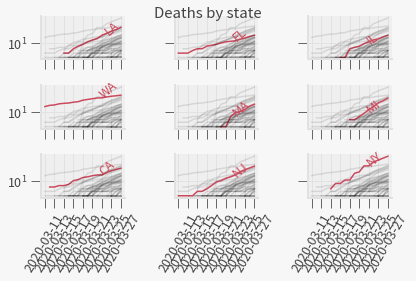

In [6]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True)
states=list(sdaily.groupby("state").max().sort_values("positive").tail(9).index)
i = 0
for j in range(len(ax)):
    for k in range(len(ax[j])):
        stateplot(states[i], "death", ax[j][k])
        i = i + 1
fig.suptitle("Deaths by state")
fig.tight_layout()

Text(0, 0.5, 'positive tests')

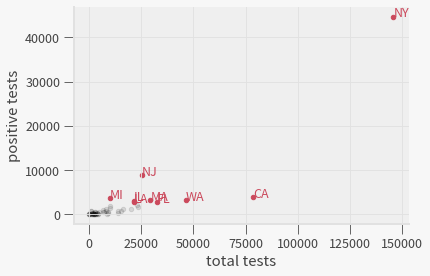

In [7]:
latest = sdaily.loc[sdaily["date"]==sdaily["date"].max(),:].copy()
latest.loc[:,"focus"]= latest["state"].map(lambda x: x in states)
def scatterlabels(xvar, yvar, ax):
    for f, df in latest.groupby("focus"):
        if f :
            df.plot(xvar,yvar, kind="scatter", color=colors[1], alpha=1, ax=ax)
            for i in df.index:
                ax.annotate(df.loc[i,"state"], (df.loc[i,xvar], df.loc[i,yvar]), color=colors[1])
        else:
            df.plot(xvar, yvar, kind="scatter", color="black", alpha=0.1, ax=ax)
    return(ax)

fig, ax = plt.subplots()
ax = scatterlabels("total","positive",ax)
ax.set_xlabel('total tests')
ax.set_ylabel('positive tests')

Text(0, 0.5, 'deaths')

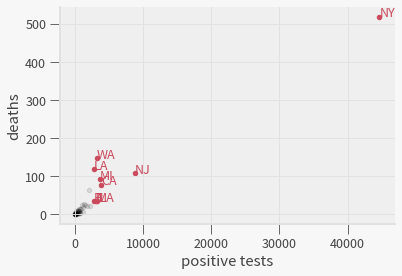

In [8]:
fig, ax = plt.subplots()
ax = scatterlabels("positive","death",ax)
ax.set_xlabel('positive tests')
ax.set_ylabel('deaths')

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,focus,prate
16,2020-03-27,IL,3060.0,18516.0,NaN,NaN,34.0,21576,2020-03-27T20:00:00Z,21576,17,8.0,0.0,4423.0,522.0,4945.0,True,0.141824
41,2020-03-27,PA,2218.0,21016.0,NaN,551.0,22.0,23234,2020-03-27T20:00:00Z,23234,42,6.0,551.0,4575.0,531.0,5106.0,False,0.095464
47,2020-03-27,TX,1731.0,21935.0,NaN,NaN,23.0,23666,2020-03-27T20:00:00Z,23666,48,5.0,0.0,1907.0,335.0,2242.0,False,0.073143
34,2020-03-27,NJ,8825.0,16547.0,NaN,NaN,108.0,25372,2020-03-27T20:00:00Z,25372,34,27.0,0.0,2886.0,1949.0,4835.0,True,0.347824
21,2020-03-27,MA,3240.0,26131.0,NaN,219.0,35.0,29371,2020-03-27T20:00:00Z,29371,25,10.0,0.0,4927.0,823.0,5750.0,True,0.110313
10,2020-03-27,FL,2765.0,28186.0,1517.0,456.0,34.0,32468,2020-03-27T20:00:00Z,30951,12,6.0,50.0,4445.0,410.0,4855.0,True,0.089335
52,2020-03-27,WA,3207.0,43173.0,NaN,NaN,147.0,46380,2020-03-27T20:00:00Z,46380,53,15.0,0.0,11461.0,627.0,12088.0,True,0.069146
5,2020-03-27,CA,3879.0,17380.0,57400.0,746.0,78.0,78659,2020-03-27T20:00:00Z,21259,6,13.0,746.0,0.0,873.0,873.0,True,0.182464
37,2020-03-27,NY,44635.0,101118.0,NaN,6844.0,519.0,145753,2020-03-27T20:00:00Z,145753,36,134.0,0.0,16272.0,7377.0,23649.0,True,0.306237


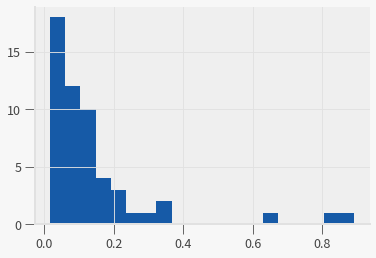

In [9]:
latest['prate'] = latest['positive']/(latest['positive']+latest['negative'])
latest['prate'].hist(bins=20)
latest.sort_values('total').tail(9)